This notebook breaks down the process I use to fit to a real (simulated) lens image and subtract the residuals out. I already have done toy problems so I'm going to break down the process I use and see how it holds up. 

In [1]:
import pyfits
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.xkcd()
#replace with the correct one on your machine. 
image_filepath = '/home/jeffrey/Bayesian_Image_Modeling/test_images/CFHTLS_072_2003_g.fits'
try:
    fitsImage = pyfits.open(image_filepath)
    print 'Image loaded OK!'
except IOError:
    print 'ERROR: Invalid filename. Make sure you put in the right one above.'

Image loaded OK!


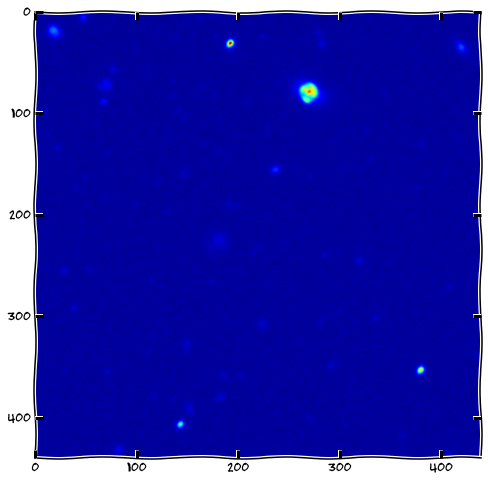

In [2]:
image = fitsImage[0].data
img_y, img_x = image.shape
from IPython.core.pylabtools import figsize
figsize(10,8)
plt.imshow(image)

So that's a big image with a lot going on. Fortunately, we're assuming that the center of the galaxy of interest is a given, and I will slice it out below. 

19 14


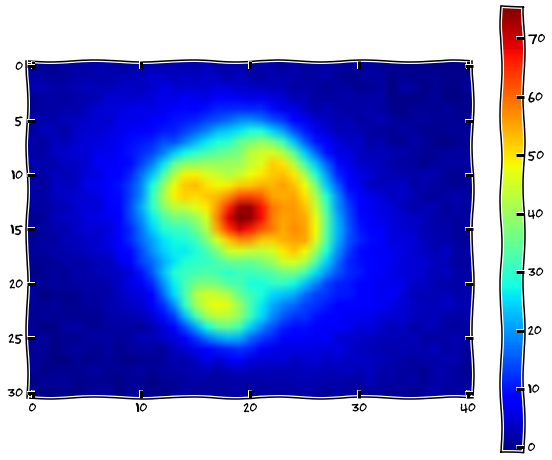

In [3]:
image = image[65:96,250:291]
#take the center as the maximum
img_cy, img_cx =  np.unravel_index(image.argmax(), image.shape)
print img_cx, img_cy
img_y, img_x = image.shape
plt.imshow(image)
plt.colorbar()

Now, all there is to do is apply the algorithm I used in my toy problem here, with some tweaks. 

In [4]:
import pymultinest
N = 2# number of Gaussians to fit with. Start with 2 for sanity's sake.

err = .1
inv_sigma2 = 1./(err**2) # Error. Not sure of it's importance.

#Gaussian function, used extensively below
#Note can change so cx and cy aren't parameters snice they'll always be img_cx and img_cy
def gaussian(x,y, cx,cy,a,r):
    return a*np.exp(-1./(r**2)*((x-cx)**2+(y-cy)**2))

#prior for multinest
def prior(theta, ndim, nparams):
#theta = [A1, A2,...AN, R1,...RN]
    for n in xrange(N):
        theta[n] = 10**(3*theta[n]) #log uniform prior
        theta[n+N] = 10**(theta[n+N]) #log uniform prior

x,y = [np.arange(i) for i in (img_x, img_y)]
xx, yy = np.meshgrid(x,y) #this meshgrid is super useful for optimization

#log liklihood of a model
def loglike(theta, ndim, nparams):
    As = theta[:N]
    Rs = theta[N:2*N] #have to define the end for some reason. Likely C-code problems
    model = sum(gaussian(xx,yy, img_cx, img_cy, A, R) for A,R in zip(As,Rs)) #sum up the model
    return -.5*(np.sum(((image-model)**2)*inv_sigma2-np.log(inv_sigma2)))#subtract from the data assuming gaussian noise.

parameters = []
parameters.extend(['A%d'%n for n in xrange(N)])
parameters.extend(['R%d'%n for n in xrange(N)])
n_params = len(parameters) #N*2

In [5]:
#replace with another prefix or directory name that you want the files to go to.
base_output = '/home/jeffrey/Documents/Rimg_1'

In [6]:
#Run the actual MCMC sampler. This may take a little while. 
pymultinest.run(loglike, prior, n_params, outputfiles_basename = base_output, \
                resume = False, verbose = True)

  analysing data from /home/jeffrey/Documents/Rimg_1.txt
A0: 20.000000	R0: 1.400000
A1: 60.000000	R1: 8.700000


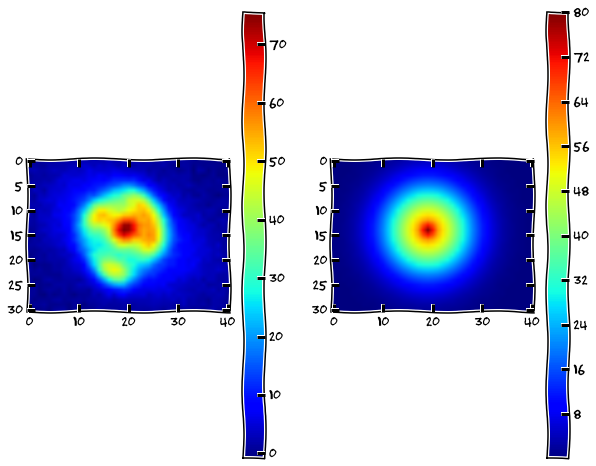

In [7]:
#read the output from the file.
analyzer = pymultinest.Analyzer(outputfiles_basename = base_output, n_params = n_params)
#There are several different functions for the analyzer object
#this one pulls some towards the end, not every sample. 
samples = analyzer.get_equal_weighted_posterior()[:,:n_params]
#split samples into 2 parts
sampled_as = samples[:, :N]
sampled_rs = samples[:, N:]

from scipy.stats import mode
#mode works metter than mean for these tests. 
#I've been using round to imporve the use of mode. Too many decimal places lead to too much randomness. 
calc_as = mode(np.round(sampled_as, decimals = -1))[0][0]
calc_rs = mode(np.round(sampled_rs, decimals = 1))[0][0]

for n,(a,r) in enumerate(zip(calc_as, calc_rs)):
    print 'A%d: %f\tR%d: %f'%(n,a,n,r)

#Sum together our results
calc_img = sum(gaussian(xx,yy, img_cx, img_cy, A,R) for A,R in zip(calc_as, calc_rs))

#show original and fit side by side
plt.subplot(121)
plt.imshow(image)
plt.colorbar()
plt.subplot(122)
plt.imshow(calc_img)
plt.colorbar()

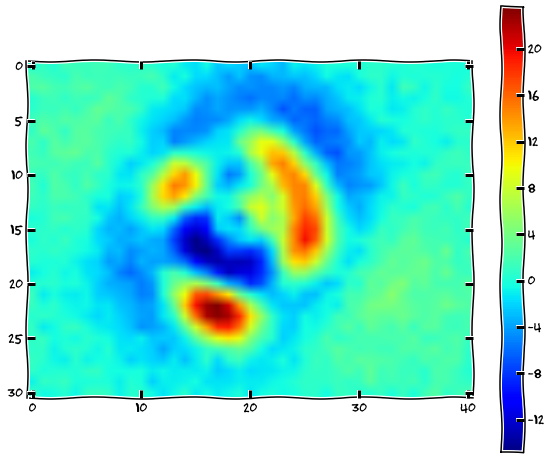

In [8]:
#subtract out our calculation and show
diffimage = image-calc_img

#diffimage[diffimage<0] = 0

plt.imshow(diffimage)
plt.colorbar()

If you look, you can see on the left and bottom there are 2 blips that likely correspond to lens parts, and probably the big arc up top, too. However, I don't like the blip in center that seems to be part of the peak that was not fit to properly. I also really don't like how it over estimated part of the peak and now there's a big negative hole.

Let's check out how the sampling went with some histograms.

(array([ 961.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  969.]),
 array([ 16.01976068,  16.4804912 ,  16.94122171,  17.40195223,
         17.86268275,  18.32341326,  18.78414378,  19.24487429,
         19.70560481,  20.16633532,  20.62706584,  21.08779636,
         21.548526

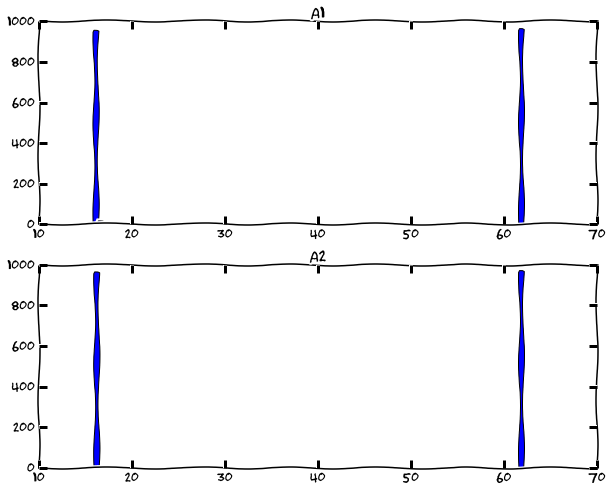

In [9]:
plt.subplot(211)
plt.title('A1')
plt.hist(samples[:,0], bins = 100)
plt.subplot(212)
plt.title('A2')
plt.hist(samples[:,1], bins = 100)

There's a strong bias to one side or the other. Some pretty good convergence, I think. Some more things to consider and problems I noticed while working on this. 

-It seems to get exponentially slower with an increased N. Multinest is nice in that it prints the acceptance fraction as it goes along. An ideal acceptance fraction should be between .2 and .5. I ran this notebook with N = 6, and the acceptance fraction dropped to .01 very quickly. This means it'll take at least 10 times as long to converge, by my most conservative estimates compared to an N=4 simulation. Multinest terminates when the uncertainty on the Bayesian Evidence is < .15 or there abouts. 

-Ultimately, I'm going to have to move from purely spherical gaussians to true multivariates, with covariance matrices. This increases the complexity of the prior dramatically, and I'm not sure how to continue with that. 

-The behavior when changing N is sometimes unpredictable. I'll have to start using a metric to compares the goodness of fits. Sometimes changing N will result in an idenctial fit because the Amplitude of the added Gaussian will converge to 0. Other times, I've had it where adding another peak makes all of them converge to 0. 

-Still unsure of emcee is a better choice than multinest. I'll probably write some code with emcee to see how it compares (once I have a method of measuring goodness of fits).

In [10]:
from scipy.stats import chisquare

a,b =  chisquare(image, f_exp = calc_img, axis = None)
print a

6646.29784982
